# Bank Churn Prediction

The Bank Churn Prediction project aims to identify customers who are at risk of leaving the bank.
Using features such as gender, age, account balance, activity level, credit score, tenure, and geography, the model learns patterns in the data and predicts the probability that a customer will churn.

This allows the bank to:

- better understand which factors influence customer attrition,

- focus retention efforts on clients who are most likely to leave,

- design more personalized communication and targeted offers.

As a result, the bank can reduce customer loss, improve customer satisfaction, and optimize its marketing and operational strategies. Ultimately, customers become more satisfied, and the bank strengthens its position while also attracting new clients.

This project covers practical, real-world aspects of data science and helps develop a deeper understanding of business logic.
By working with churn prediction, the analysis goes beyond modeling itself and focuses on how data-driven insights support strategic decisions, customer retention, and long-term business value.

In [147]:
#Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import joblib
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

In [22]:
#Loading the dataset
clients_data = pd.read_csv('../data/Bank_Churn.csv')
clients_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [23]:
#Displaying the full description without truncation ("...")
pd.set_option('display.max_colwidth', None)

In [24]:
#Columns name with description
cols_description = pd.read_csv('../data/Bank_Churn_Data_Dictionary.csv')
cols_description

,Field,Description
0,CustomerId,A unique identifier for each customer
1,Surname,The customer's last name
2,CreditScore,A numerical value representing the customer's credit score
3,Geography,"The country where the customer resides (France, Spain or Germany)"
4,Gender,The customer's gender (Male or Female)
5,Age,The customer's age
6,Tenure,The number of years the customer has been with the bank
7,Balance,The customer's account balance
8,NumOfProducts,"The number of bank products the customer uses (e.g., savings account, credit card)"
9,HasCrCard,"Whether the customer has a credit card (1 = yes, 0 = no)"


## Data preprocessing

In [25]:
#Checking the structure of our dataset
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [26]:
# Checking descriptive statistics
clients_data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [27]:
#Checking missing values
clients_data.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [28]:
clients_data.duplicated().sum()

np.int64(0)

The dataset contains no missing values and no duplicates

In [29]:
#Remove irrelevant columns
data = clients_data.drop(['CustomerId', 'Surname'], axis=1, errors='ignore').copy()

In [30]:
#Encode categorical features using one-hot encoding
data_enc = pd.get_dummies(data, columns=['Geography', 'Gender']).copy().astype(int)

In [31]:
data_enc.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0,1,1,1,101348,1,1,0,0,1,0
1,608,41,1,83807,1,0,1,112542,0,0,0,1,1,0
2,502,42,8,159660,3,1,0,113931,1,1,0,0,1,0
3,699,39,1,0,2,0,0,93826,0,1,0,0,1,0
4,850,43,2,125510,1,1,1,79084,0,0,0,1,1,0


In [157]:
#Function detecting outliers
def detect_outliers(dataset, columns):
    Q1 = dataset[columns].quantile(0.25)
    Q3 = dataset[columns].quantile(0.75)
    IQR = Q3 - Q1

    low = Q1 - 1.5 * IQR
    up = Q3 + 1.5 * IQR

    outliers = dataset[(dataset[columns] < Q1 - 1.5 * IQR) | (dataset[columns] > Q3 + 1.5 * IQR)]
    return outliers, low, up

## Exploratory Data Analysis

CreditScore:
Number of outliers 15
      CreditScore
7             376
942           376
1193          363
Age:
Number of outliers 359
     Age
58    66
85    75
104   65
Balance:
Number of outliers 0
EstimatedSalary:
Number of outliers 0


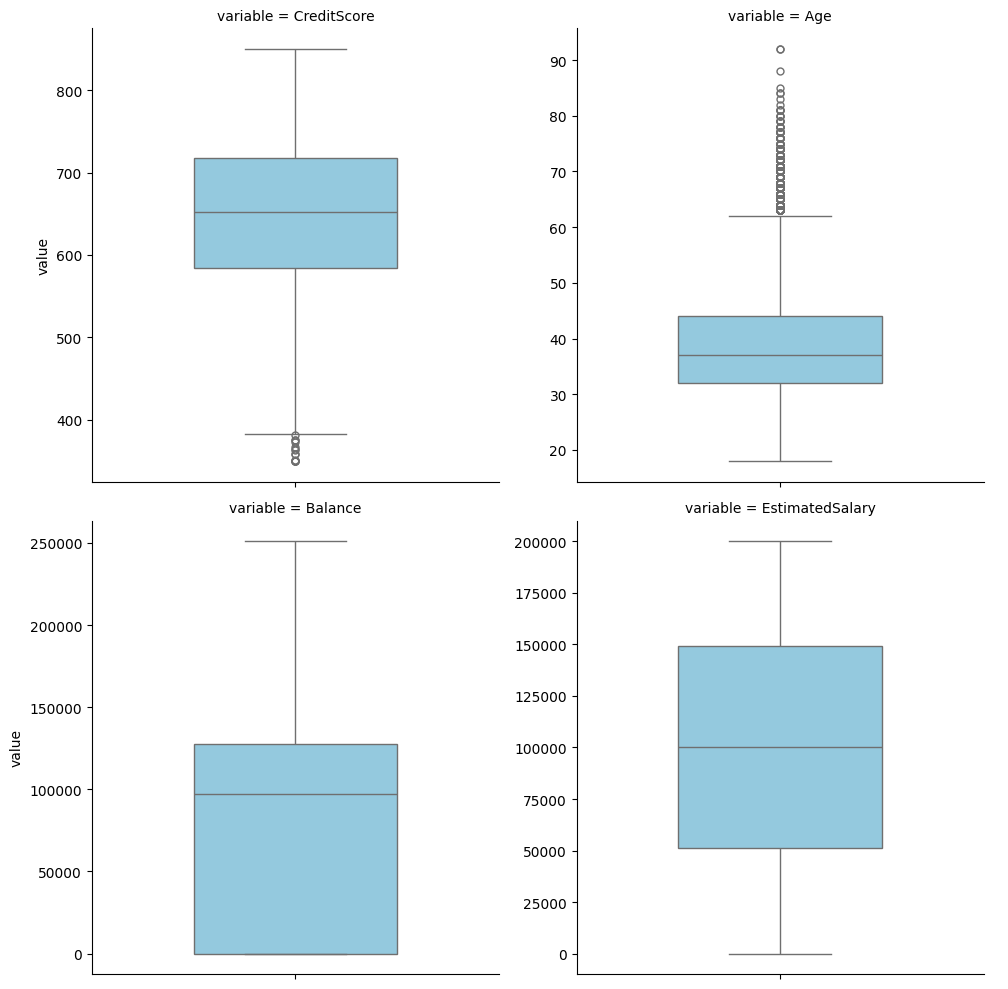

In [33]:
# Outlier visualization with separate boxplots
columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for col in columns:
    outliers, low, up = detect_outliers(data_enc, col)
    print(f'{col}:')
    print(f'Number of outliers {outliers.shape[0]}')
    if outliers.shape[0] != 0:
        print(outliers[[col]].head(3))
    else:
        continue

#Displaying boxplots 
sns.catplot(
           kind='box',
           data=clients_data[columns].melt(),
           y='value',
           col="variable",
           col_wrap=2,
           sharey=False,
           color='skyblue',
           width=0.5
)
plt.savefig('../images/Boxplots_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

The boxplots visualize the distributions of four variables: CreditScore, Age, Balance, and EstimatedSalary. CreditScore is fairly symmetric around 650 but contains some low-value outliers. Notably, Age is right-skewed with a median around 37 and significant high-value outliers, indicating a generally younger demographic with a tail of older individuals. Balance shows a wide spread, and the fact that the bottom of the box touches zero suggests that a significant portion of the dataset has a balance of 0, while the median is close to 100,000. Finally, EstimatedSalary appears very uniformly distributed with a median also near 100,000. The last two variables have no outliers.

We do not remove the outliers in these variables, as they represent valid business information and could be important for predicting customer behavior.

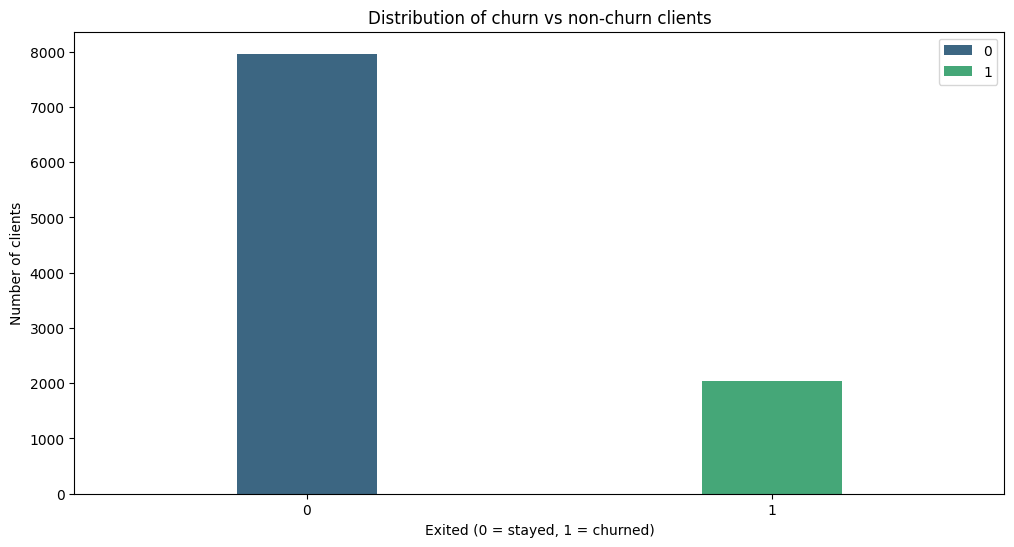

In [34]:
#Displaying barplots of clients who churned and stayed
exit_counter = data_enc.groupby('Exited').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=exit_counter.index, y=exit_counter.values, hue=exit_counter.index, width=0.3, palette='viridis')
plt.title('Distribution of churn vs non-churn clients')
plt.xlabel('Exited (0 = stayed, 1 = churned)')
plt.ylabel('Number of clients')
plt.legend()
plt.savefig('../images/Distribution_churn_vs_not_churn.png', dpi=300, bbox_inches='tight')
plt.show()

The barplot clearly shows a strong imbalance between clients who stayed and those who churned.
The dark blue bar represents customers who remained with the bank — approximately 8,000 clients.
In contrast, the green bar shows that only about 2,000 clients churned, which is roughly four times fewer.

Such a significant class imbalance can create challenges in the predictive modeling stage. A model trained on imbalanced data may learn to predict only the majority class (clients who stay) while failing to correctly identify the minority class (clients who churn).

It will be necessary to:

1. Apply resampling techniques, such as SMOTE or Random Over/Undersampling.

2. Perform appropriate feature scaling (e.g., StandardScaler or MinMaxScaler) depending on the models used.

3. Rely on evaluation metrics better suited for imbalanced classification, such as:

- Recall

- Precision

- F1-Score

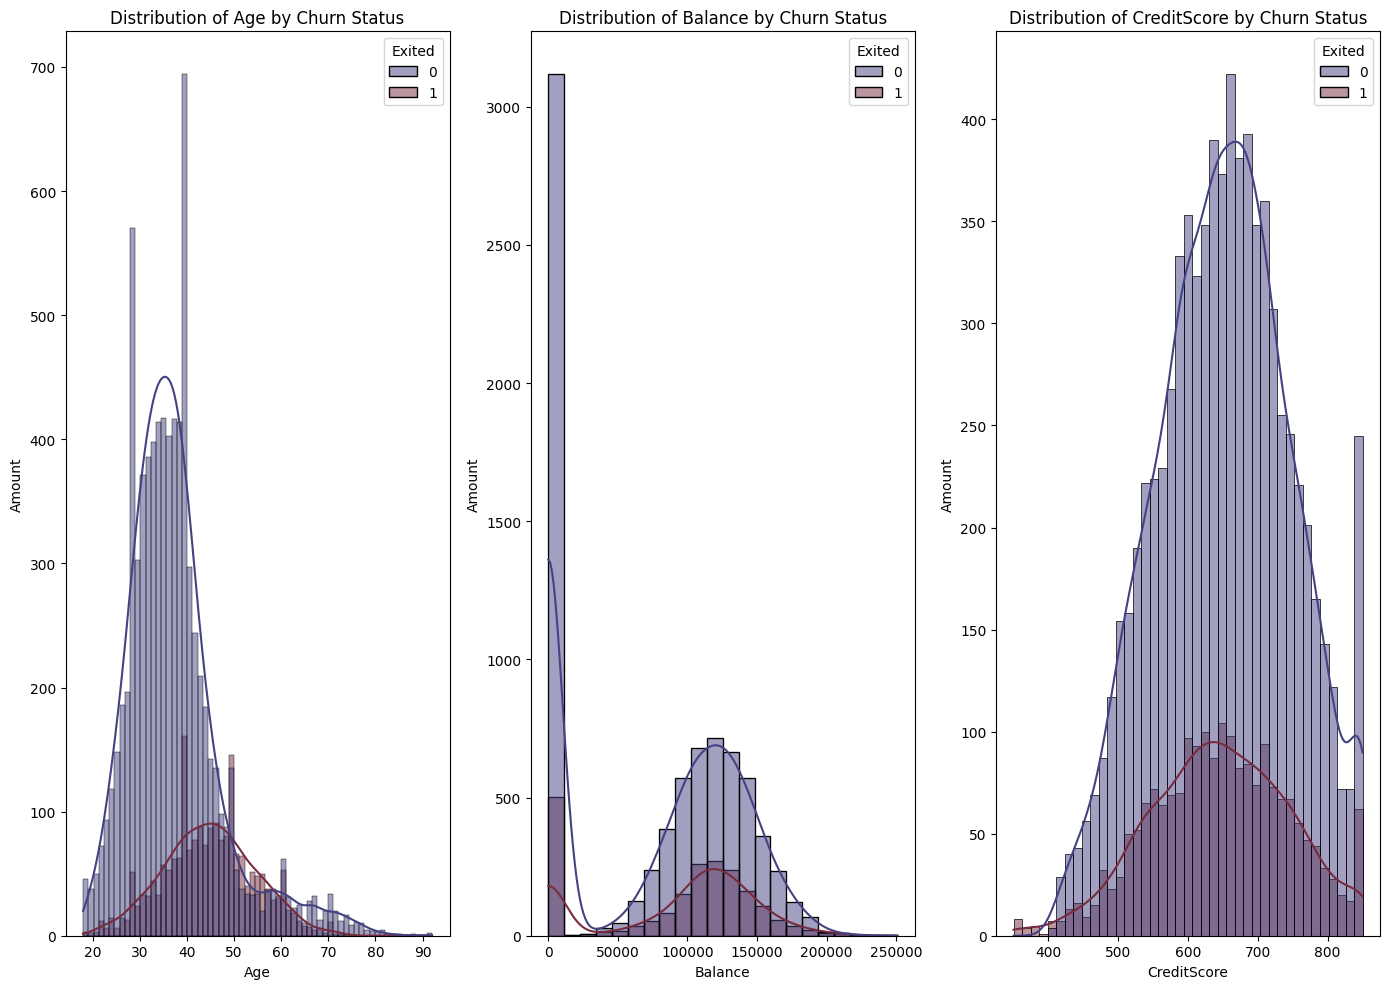

In [35]:
#Numerical values to churn - histplots
fig, axes = plt.subplots(1, 3, figsize=(14, 10))

sns.histplot(data=data_enc, x='Age', hue='Exited', kde=True, palette='icefire', ax=axes[0])
axes[0].set_title('Distribution of Age by Churn Status')
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Amount")

sns.histplot(data=data_enc, x='Balance', hue='Exited', kde=True, palette='icefire', ax=axes[1])
axes[1].set_title('Distribution of Balance by Churn Status')
axes[1].set_xlabel("Balance")
axes[1].set_ylabel("Amount")

sns.histplot(data=data_enc, x='CreditScore', hue='Exited', kde=True, palette='icefire', ax=axes[2])
axes[2].set_title('Distribution of CreditScore by Churn Status')
axes[2].set_xlabel("CreditScore")
axes[2].set_ylabel("Amount")

plt.tight_layout()
plt.savefig('../images/Numerical_values_histplots.png', dpi=300, bbox_inches='tight')
plt.show()

1. **Age**:

The distribution of non-churned clients (blue) is right-skewed, peaking significantly between ages 30 and 35. In contrast, the distribution of churned clients (red) is closer to a normal distribution, with a peak around ages 45 to 50. This suggests that older clients may be more prone to churn.

2. **Balance**:

The most striking feature is the massive spike at zero balance, indicating that a large proportion of clients maintain no balance on their accounts. Notably, these zero-balance clients are significantly less likely to churn compared to those with positive balances. For clients with balance above zero, the distributions are quite similar between churned and non-churned groups. This insight suggests that clients who maintain account balances are more vulnerable to churn, making them a priority for retention efforts.

3. **Credit Score**:

The distributions for churned (red) and non-churned (blue) clients are nearly identical, both exhibiting a bell-shaped curve centered around credit scores of 600–700. Since the curves overlap almost perfectly, credit score does not appear to be a strong predictor of churn behavior.

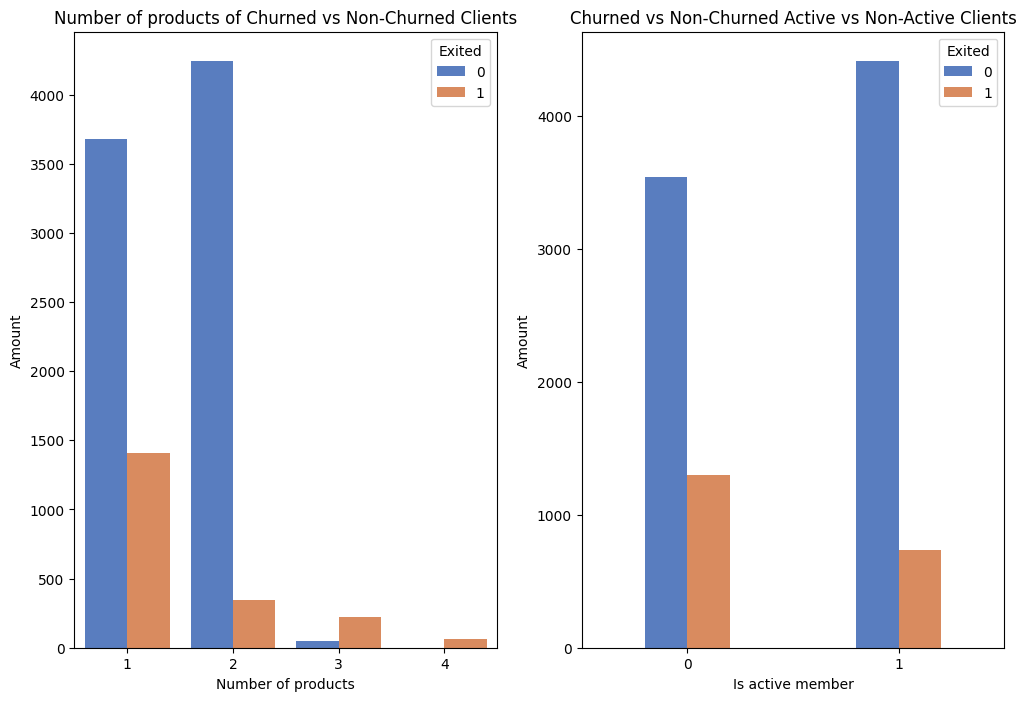

In [36]:
#Barplots with number of products and wheather the member is active

fig2, axes2 = plt.subplots(1, 2, figsize=(12, 8))

sns.countplot(data=data_enc, x='NumOfProducts', hue='Exited', ax=axes2[0], palette='muted')
axes2[0].set_title('Number of products of Churned vs Non-Churned Clients')
axes2[0].set_xlabel('Number of products')
axes2[0].set_ylabel('Amount')

sns.countplot(data=data_enc, x='IsActiveMember', hue='Exited', ax=axes2[1], palette='muted', width=0.4)
axes2[1].set_title('Churned vs Non-Churned Active vs Non-Active Clients')
axes2[1].set_xlabel('Is active member')
axes2[1].set_ylabel('Amount')

plt.savefig('../images/Number_of_products_and_active_clients_countplots.png', dpi=300, bbox_inches='tight')
plt.show()

The chart on the left reveals a significant correlation between product ownership and churn. Clients holding a single product are highly susceptible to attrition, as evidenced by the substantial size of the orange bar.

In contrast, the group with two products represents the 'sweet spot' for retention, demonstrating the highest loyalty and lowest churn rate.

Interestingly, this trend reverses for product-heavy clients: those with 3 products show a high exit rate, while retention for those with 4 products is near zero. 

**Conclusion**: Excessive product ownership correlates with higher churn risk, whereas the 2-product segment represents the most stable and satisfied customer base.

The second chart indicates that non-active members are more prone to churn; the ratio of clients who left versus those who stayed is clearly unfavorable in this group.

Among active members, the number of clients who stayed (blue bar) increased compared to non-active members, while the number of those who churned (salmon bar) decreased significantly.

**Conclusion**: Low activity is a strong risk factor. The bank should prioritize re-engagement strategies for non-active members to reduce attrition.

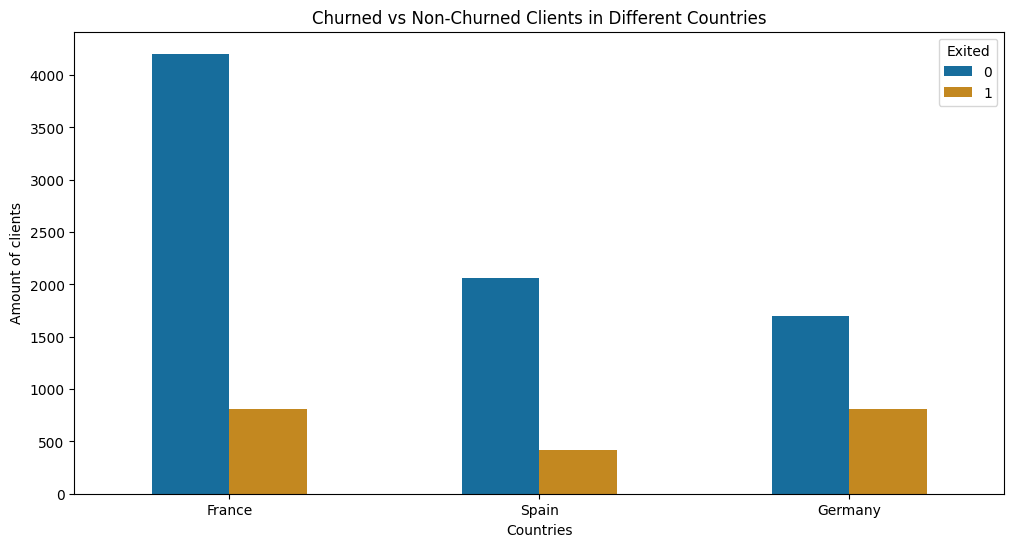

In [37]:
#How geography affects on clients decisions

plt.figure(figsize=(12, 6))
sns.countplot(data=clients_data, x='Geography', hue='Exited', palette='colorblind', width=0.5)
plt.title('Churned vs Non-Churned Clients in Different Countries')
plt.xlabel('Countries')
plt.ylabel('Amount of clients')
plt.savefig('../images/Geographical_influence_countplots.png', dpi=300, bbox_inches='tight')
plt.show()

The chart illustrates customer churn status across different countries. France leads in total membership, with over 4,000 retained clients and approximately 800 who churned. Spain has a customer base roughly half the size of France, with fewer than 500 exits. Interestingly, Germany exhibits the most unfavorable retention ratio; despite having the smallest number of retained clients, it has a disproportionately high number of customers who churned.

To sum up, France is the bank's largest market, accounting for the majority of the customer base with a relatively stable retention rate. In contrast, Germany presents a significant challenge, as it shows a disproportionately high churn rate despite having the smallest number of retained clients, suggesting underlying issues specific to that region. Spain occupies a middle ground, with a smaller market share than France but a healthier retention ratio than Germany.

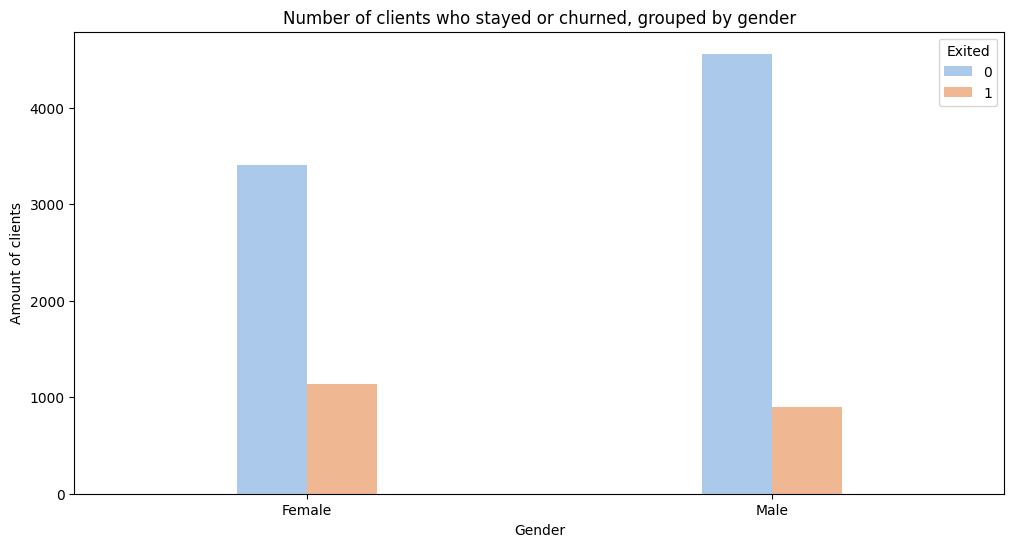

In [38]:
#Number of clients who stayed or churned, grouped by gender

plt.figure(figsize=(12, 6))
sns.countplot(data=clients_data, x='Gender', hue='Exited', palette='pastel', width=0.3)
plt.title('Number of clients who stayed or churned, grouped by gender')
plt.xlabel('Gender')
plt.ylabel('Amount of clients')
plt.savefig('../images/Clients_by_gender_countplot.png', dpi=300, bbox_inches='tight')
plt.show()

These bar plots show that there are slightly more male clients (around 4,500), while the number of female clients is approximately 1000 lower. It is worth noting that although the bank has more male clients, males are less likely to churn compared to females. 

This suggests that the female segment may be more vulnerable to churn. Therefore, it could be beneficial for the bank to focus on this minority group and explore strategies to increase their retention.

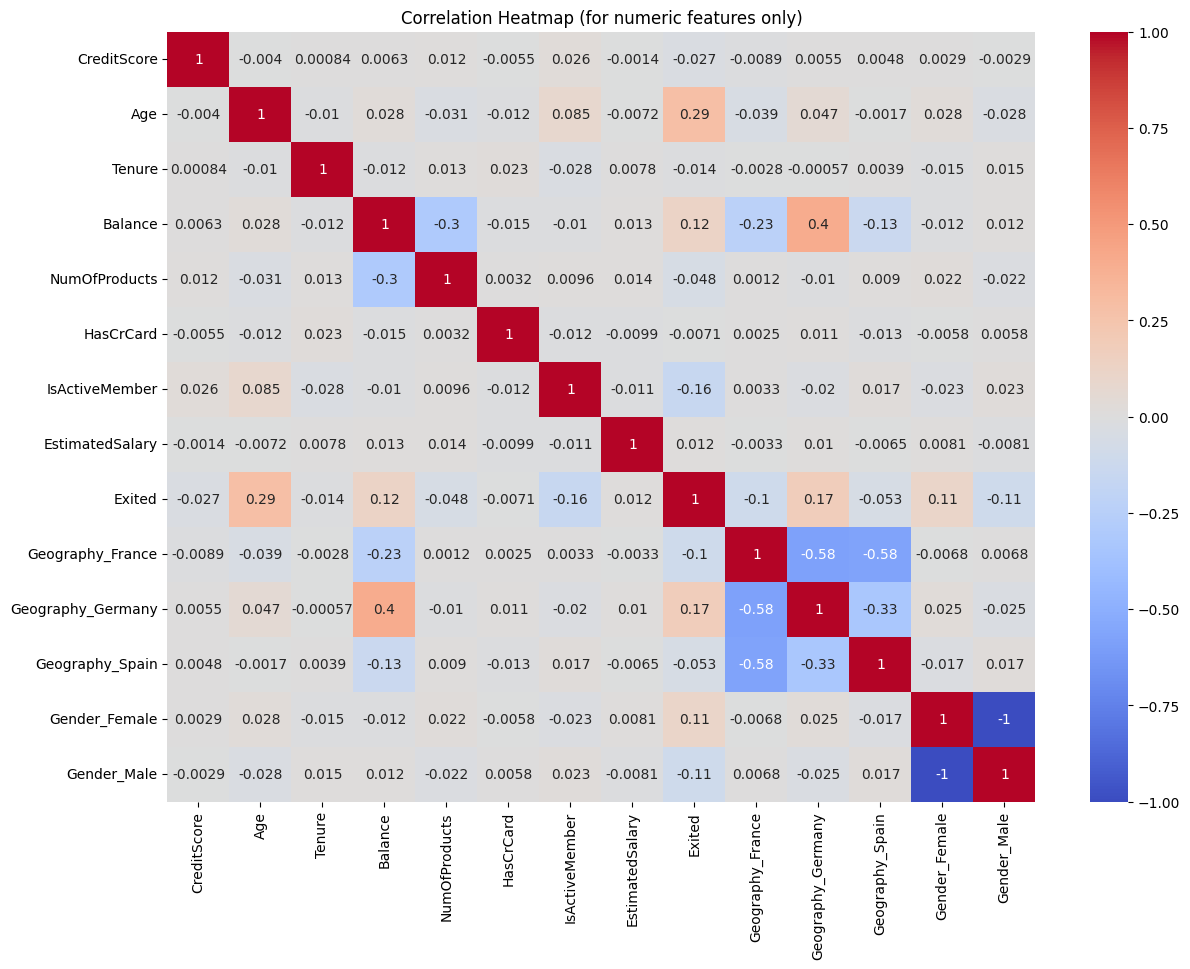

In [39]:
#Heatmap of numerical values

numeric_cols = data_enc.select_dtypes(include=['int64', 'float64'])
corr = numeric_cols.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (for numeric features only)')
plt.savefig('../images/Numerical_values_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

The heatmap illustrates the Pearson correlation coefficients between numerical features. Coefficients approaching 1 denote a strong positive correlation, whereas those approaching -0.3 denote a strong negative correlation.

The most significant predictor of the target variable ('Exited') is 'Age', with a coefficient of 0.29. A weak positive correlation is also observed between 'Balance' and 'Exited'. 'CreditScore', however, exhibits a negligible negative correlation.

These metrics corroborate the insights from the distribution plots, confirming that Credit Score has minimal predictive power regarding customer attrition. On the other hand, 'Age' and 'Balance' show a stronger correlation with churn and should be used to drive the bank's new strategic initiatives.

## Model Building

In [40]:
#Selecting features
X = data_enc.drop('Exited', axis=1)
y = data_enc['Exited']

In [41]:
#Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [42]:
#Scaling to balance the features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
#Using the SMOTE technique to handle the class imbalance problem
smote = SMOTE(random_state=42)

#Only using on train set
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

### First Model - Logistic Regression

In [148]:
#Pipeline with SMOTE and scaling
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=101)),
    ('model_lr', LogisticRegression(max_iter=1000, random_state=101))
])

In [149]:
#Setting hyperparameters to improve model performance
param_log = [
    {
        "model_lr__solver": ["liblinear"],
        "model_lr__penalty": ["l1", "l2"],
        "model_lr__C": [0.001, 0.01, 0.1, 1, 10]
    },
    {
        "model_lr__solver": ["saga"],
        "model_lr__penalty": ["l1", "l2"],
        "model_lr__C": [0.001, 0.01, 0.1, 1, 10]
    },
    {
        "model_lr__solver": ["saga"],
        "model_lr__penalty": ["elasticnet"],
        "model_lr__l1_ratio": [0, 0.3, 0.5, 0.7, 1],
        "model_lr__C": [0.001, 0.01, 0.1, 1, 10]
    }
]

In [150]:
grid_log = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_log,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [151]:
#Training model
grid_log.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


,estimator,Pipeline(step..._state=101))])
,param_grid,"[{'model_lr__C': [0.001, 0.01, ...], 'model_lr__penalty': ['l1', 'l2'], 'model_lr__solver': ['liblinear']}, {'model_lr__C': [0.001, 0.01, ...], 'model_lr__penalty': ['l1', 'l2'], 'model_lr__solver': ['saga']}, ...]"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [152]:
best_log_model = grid_log.best_estimator_

#Prediction
log_model_predict = best_log_model.predict(X_test)

#Predicted probability for class 1
log_model_predict_proba = best_log_model.predict_proba(X_test)[:, 1]

In [153]:
#Exploring model coefficients
coefs = best_log_model.named_steps['model_lr'].coef_[0]

coeffs = pd.DataFrame({
    'Feature': X_train.columns,
    'Weight': coefs
})

coeffs = coeffs.sort_values(by='Weight', ascending=False)

print(coeffs)

              Feature    Weight
1                 Age  0.498774
9   Geography_Germany  0.173081
3             Balance  0.056168
11      Gender_Female  0.038432
0         CreditScore  0.000000
4       NumOfProducts  0.000000
2              Tenure  0.000000
5           HasCrCard  0.000000
7     EstimatedSalary  0.000000
10    Geography_Spain  0.000000
8    Geography_France  0.000000
12        Gender_Male -0.038432
6      IsActiveMember -0.194993


From the table above, we can see that the features most associated with increased churn are Age, Balance, EstimatedSalary, and customers from Germany and Spain.

From the EDA charts, these results align with expectations:

- Age is the strongest indicator of churn, while Balance also contributes but to a lesser extent. Together, these features help the model identify clients who are more likely to leave.

- EstimatedSalary and Gender_Female have a smaller impact on churn.

- Geography_Germany appears particularly important, which is consistent with the “Churned vs Non-Churned Clients by Country” chart.

This insight suggests that retention strategies could focus on older clients with higher balances, and special attention might be needed for clients in Germany, while Spanish and France clients are less critical factors.

In [154]:
classification_report(y_test, log_model_predict, output_dict=True)

{'0': {'precision': 0.9127625201938611,
  'recall': 0.7165504121750158,
  'f1-score': 0.8028419182948491,
  'support': 1577.0},
 '1': {'precision': 0.41338582677165353,
  'recall': 0.7446808510638298,
  'f1-score': 0.5316455696202531,
  'support': 423.0},
 'accuracy': 0.7225,
 'macro avg': {'precision': 0.6630741734827573,
  'recall': 0.7306156316194228,
  'f1-score': 0.6672437439575511,
  'support': 2000.0},
 'weighted avg': {'precision': 0.8071443495350642,
  'recall': 0.7225,
  'f1-score': 0.7454838905501721,
  'support': 2000.0}}

In [155]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, log_model_predict_proba):.4f}")

ROC-AUC Score: 0.7903


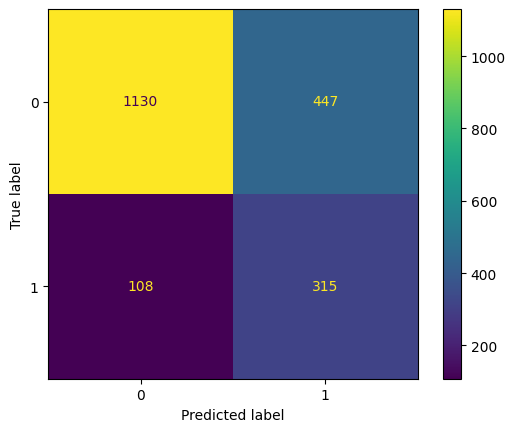

In [156]:
ConfusionMatrixDisplay.from_estimator(best_log_model, X_test, y_test)
plt.savefig('../images/Confusion_Matrix_model1.png', dpi=300, bbox_inches='tight')

The model achieved the highest Recall (75%), successfully identifying 315 out of 423 churners (missing only 108). However, the Precision remains low at 40%. The Confusion Matrix reveals a high number of False Positives (447), which means that for every 10 customers flagged as 'at risk,' 6 are actually loyal.

The relatively low F1-score (~0.53) suggests that the relationships in the dataset are non-linear, which this linear model struggles to capture. Consequently, the model adopted an 'aggressive' prediction strategy, prioritizing high Recall at the expense of Precision.

The ROC-AUC score of 0.7903 indicates that, despite its limitations in Precision, the model still has a solid ability to rank customers by churn risk. It can separate churners from non-churners significantly better than random guessing, even if the final classification threshold leads to many False Positives.

Conclusion: Due to its high False Positive rate, this model is suitable only for low-cost retention campaigns, where mistakenly targeting a loyal customer carries a negligible financial cost.

### Second Model - Random Forest

In [53]:
#Setting some hyperparameters for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

scoring = {
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

In [54]:
#Using Random Forest Classifier
rfc_model = RandomForestClassifier(random_state=42)

In [55]:
random_search = RandomizedSearchCV(
    estimator=rfc_model,
    param_distributions=param_grid,
    n_iter=50,  
    cv=5,
    scoring=scoring,
    refit='f1', 
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True 
)

In [56]:
random_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'class_weight': ['balanced', 'balanced_subsample', ...], 'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,50
,scoring,"{'f1': 'f1', 'precision': 'precision', 'recall': 'recall', 'roc_auc': 'roc_auc'}"
,n_jobs,-1
,refit,'f1'
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [57]:
#Model best parameters
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'class_weight': None}

In [58]:
best_rfc = random_search.best_estimator_

In [59]:
rfc_pred = best_rfc.predict(X_test_scaled)

rfc_pred_proba = best_rfc.predict_proba(X_test_scaled)[:, 1]

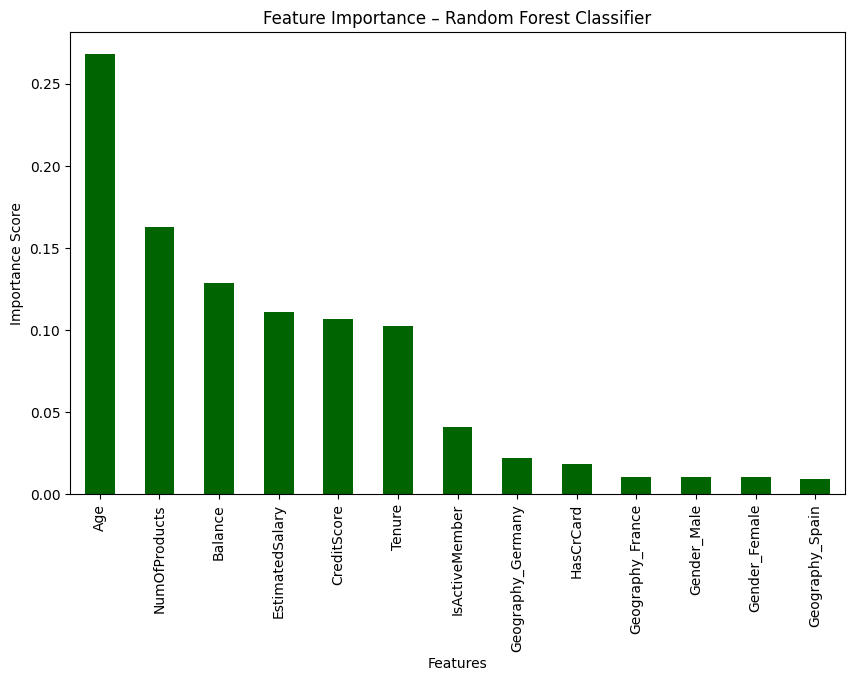

In [60]:
#Features importance
rfc_importances = best_rfc.feature_importances_
features_rfc = pd.Series(rfc_importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
features_rfc.plot(kind='bar', color='darkgreen')
plt.title('Feature Importance – Random Forest Classifier')
plt.xlabel('Features')
plt.ylabel('Importance Score')

plt.savefig('../images/Feature_importance_model2.png', dpi=300, bbox_inches='tight')
plt.show()

The Feature Importance plot reveals exactly what drives the model's decisions. This confirms that the relationships are non-linear, which is why this tree-based model outperformed linear regression.

Dominant Factors:

- Age: This is by far the strongest predictor. As seen in the EDA, older customers are much more likely to churn.

- NumOfProducts: The second most critical feature. This validates the finding that customers with 3 or 4 products have a very high churn rate.

- Balance: Financial status plays a major role, likely differentiating between active/high-value clients and dormant ones.

Geography & Gender: These are the least important features for the Random Forest model. The model relies more on behavioral and financial metrics than on demographics.

In [61]:
classification_report(y_test, rfc_pred, output_dict=True)

{'0': {'precision': 0.9043927648578811,
  'recall': 0.8877615726062144,
  'f1-score': 0.896,
  'support': 1577.0},
 '1': {'precision': 0.6084070796460177,
  'recall': 0.6501182033096927,
  'f1-score': 0.6285714285714286,
  'support': 423.0},
 'accuracy': 0.8375,
 'macro avg': {'precision': 0.7563999222519494,
  'recall': 0.7689398879579535,
  'f1-score': 0.7622857142857142,
  'support': 2000.0},
 'weighted avg': {'precision': 0.841791792435572,
  'recall': 0.8375,
  'f1-score': 0.8394388571428572,
  'support': 2000.0}}

In [62]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, rfc_pred_proba):.4f}")

ROC-AUC Score: 0.8728


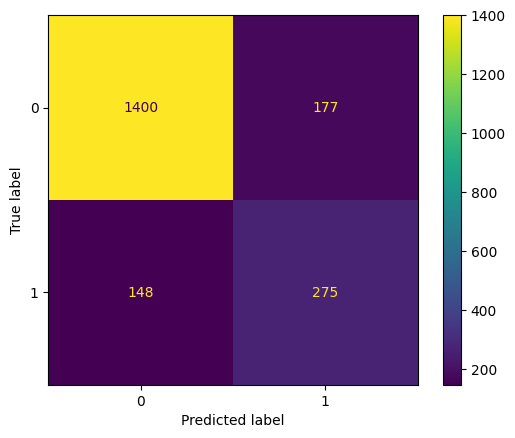

In [63]:
ConfusionMatrixDisplay.from_estimator(best_rfc, X_test_scaled, y_test)
plt.savefig('../images/Confusion_Matrix_model2.png', dpi=300, bbox_inches='tight')
plt.show()

The final model prioritizes a balance between profitability and risk detection. Unlike the aggressive baseline, it significantly reduces False Positives, preventing resource wastage on loyal clients.

- Precision & F1-Score: Significantly improved (Precision: 41% $\rightarrow$ 61%, F1: 51% $\rightarrow$ 63%),

- Recall: Dropped by ~10% as a strategic trade-off for higher precision,

- ROC-AUC: Achieved 0.87, confirming the model's robust ability to distinguish churners from non-churners,

- Feature Importance: 'Age' and 'Balance' remain the top predictors, while the weight of 'Geography' has decreased.

Focus retention efforts on older customers and those with three or more products. The improved precision means you can offer more valuable incentives without heavily targeting loyal customers by mistake.

### Third model - LightGBM

In [132]:
#Computing class weights for LightGBM
class_weight_ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

In [133]:
#Pipeline for LightGBM
pipe_lgbm = Pipeline([
    ('scaler', RobustScaler()),
    ('model_lgbm', LGBMClassifier(
        class_weitgh='balanced',
        random_state=42,
        boosting_type='gbdt',
        n_jobs=-1,
        verbose=-1,
        importance_type='gain'
    ))
])

In [134]:
#Setting hyperparameters for LightGBM
param_lgbm = {
    'model_lgbm__n_estimators': [200, 400, 800, 1200],
    'model_lgbm__learning_rate': [0.01, 0.05, 0.1],
    'model_lgbm__num_leaves': [63, 127, 255],
    'model_lgbm__max_depth': [-1, 10, 15, 20],
    'model_lgbm__min_child_samples': [10, 20, 50, 100],
    'model_lgbm__subsample': [0.5, 0.8, 1.0],
    'model_lgbm__colsample_bytree': [0.5, 0.8, 1.0],
    'model_lgbm__reg_alpha': [0, 0.001, 0.01, 0.1],
    'model_lgbm__reg_lambda': [0, 0.001, 0.01, 0.1],
    'model_lgbm__min_split_gain': [0, 0.001, 0.01],
    'model_lgbm__subsample_freq': [0, 5, 10],
    'model_lgbm__min_child_weight': [1e-5, 1e-3, 0.01],
    'model_lgbm__scale_pos_weight': [1, np.sqrt(class_weight_ratio), class_weight_ratio]
}

In [135]:
#Using StratifiedKFold for better class distribution in folds and RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_lgbm = RandomizedSearchCV(
    estimator=pipe_lgbm,
    param_distributions=param_lgbm,
    n_iter=50,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

In [136]:
random_search_lgbm.fit(X_train, y_train)
best_lgbm_model = random_search_lgbm.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [137]:
lgbm_predict = best_lgbm_model.predict(X_test)

lgbm_predict_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

c:\Users\Przemek\miniforge3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Przemek\miniforge3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


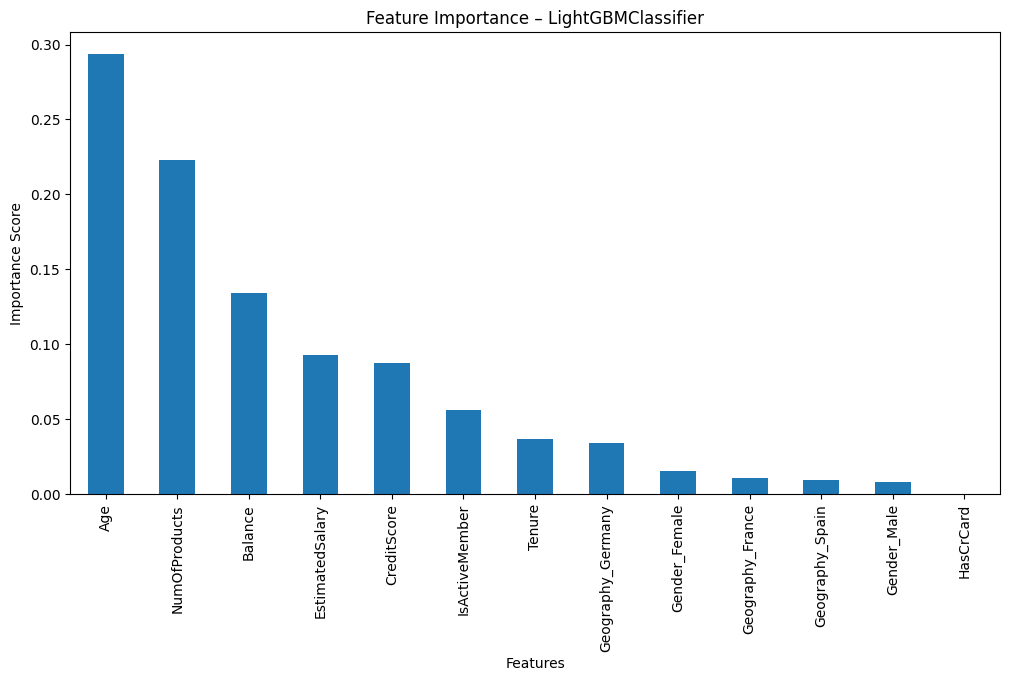

In [139]:
#Features importance for next model

lgbm_importances = best_lgbm_model.named_steps['model_lgbm'].feature_importances_
features_lgbm = pd.Series(lgbm_importances, index=X.columns).sort_values(ascending=False)
lgbm_importances_normalized = features_lgbm / features_lgbm.sum()

plt.figure(figsize=(12, 6))
lgbm_importances_normalized.plot(kind='bar')
plt.title('Feature Importance – LightGBMClassifier')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.savefig('../images/Feature_importance_model3.png', dpi=200, bbox_inches='tight')
plt.show()

Important information and shifts compared to the previous model:

- Age remains the most important feature, contributing approximately 30% to the model’s predictions. 

- NumOfProducts and Balance also remain key predictors, with their importance scores slightly increasing compared to the previous model. 

- The feature that experienced the largest drop in importance is Tenure, with its importance decreasing by roughly half.

- Geography and Gender features continue to have relatively low importance scores.

c:\Users\Przemek\miniforge3\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


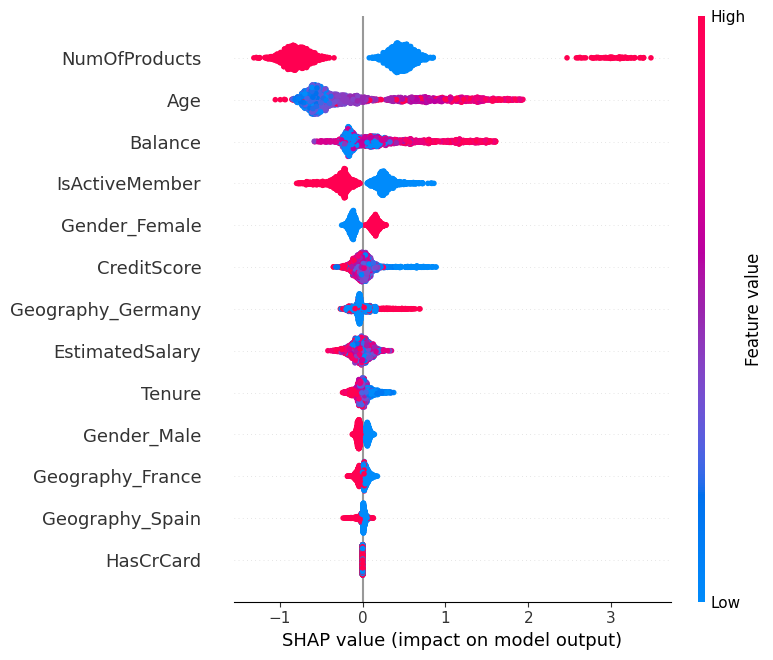

<Figure size 640x480 with 0 Axes>

In [159]:
#SHAP values for LightGBM model
exp = shap.TreeExplainer(best_lgbm_model.named_steps['model_lgbm'])
shap_val = exp.shap_values(X_test_scaled)

shap.summary_plot(shap_val, X_test)

plt.savefig('../images/Feature_value_model3.png', dpi=300, bbox_inches='tight')
plt.show()

Based on the SHAP summary plots and the feature importance analysis, the LightGBM model identifies:

- NumOfProducts and Age as the primary drivers of customer churn. Specifically, customers with a high number of products (3 or 4) or those who are older (particularly 45+) are at significantly higher risk of leaving the bank. 

- IsActiveMember status is another crucial factor, with inactivity strongly pushing predictions towards churn. 

- Geography also plays a key role, with German customers exhibiting a markedly higher churn probability than those from other regions. 

- Finally, financial indicators like Balance contribute to the prediction, where higher balances are associated with increased churn risk, while CreditScore has surprisingly low predictive power.

In [160]:
classification_report(y_test, lgbm_predict, output_dict=True)

{'0': {'precision': 0.9001240694789082,
  'recall': 0.9201014584654407,
  'f1-score': 0.9100031357792412,
  'support': 1577.0},
 '1': {'precision': 0.6752577319587629,
  'recall': 0.6193853427895981,
  'f1-score': 0.6461159062885327,
  'support': 423.0},
 'accuracy': 0.8565,
 'macro avg': {'precision': 0.7876909007188355,
  'recall': 0.7697434006275194,
  'f1-score': 0.778059521033887,
  'support': 2000.0},
 'weighted avg': {'precision': 0.8525648390933975,
  'recall': 0.8565,
  'f1-score': 0.8541909867419563,
  'support': 2000.0}}

In [143]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, lgbm_predict_proba):.4f}")

ROC-AUC Score: 0.8844


c:\Users\Przemek\miniforge3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


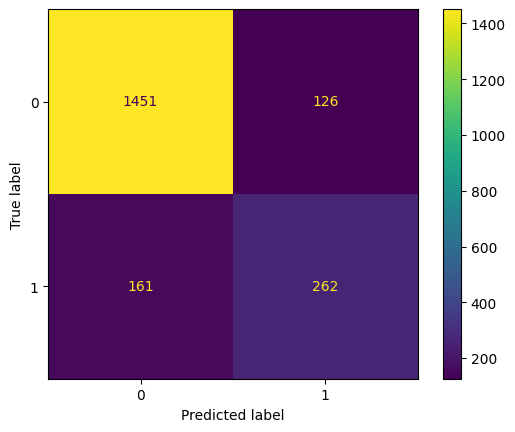

In [144]:
ConfusionMatrixDisplay.from_estimator(random_search_lgbm, X_test, y_test)
plt.savefig('../images/Confusion_Matrix_model3.png', dpi=300, bbox_inches='tight')
plt.show()

The model's ability to detect churners is decent but shows room for improvement compared to the non-churn class.

- Precision (67.5%): When the model flags a customer as a churner, it is correct about two-thirds of the time. This means there is a moderate rate of false alarms (customers flagged as churners who actually stay).

- Recall (62%): The model identifies approximately 62% of the actual churners. This means it misses roughly 38% of customers who end up leaving the bank.

- F1-Score (65%): While lower than the majority class score, an F1-score of 65% is often considered acceptable for a minority class in imbalanced datasets, though increasing this would be a primary goal for model refinement.

Summary: 

The model is highly effective at identifying loyal customers but is moderately effective at spotting those at risk of churning. Nevertheless, it outperformed all other tested algorithms, delivering the most robust and business-viable results.

In [158]:
#Saving best model

model_to_save = random_search.best_estimator_
joblib.dump(model_to_save, '../models/churn_lightgbm_model.joblib')

['../models/churn_lightgbm_model.joblib']

## Project Conclusion & Executive Summary

In this project, I evaluated three predictive models to address customer churn: Logistic Regression, Random Forest, and LightGBM. The goal was to balance the ability to detect churners (Recall) with the cost of false alarms (Precision).

- Logistic Regression: Achieved the highest Recall (74%) but proved too aggressive, resulting in low Precision (41%) and a poor F1-score (53%). This model would generate excessive false alarms, leading to wasted retention budget.

- Random Forest: Performed better, offering a balanced trade-off between Precision (61%) and Recall (65%), but lacked the superior discriminative power of boosting algorithms.

- LightGBM: Emerged as the top performer after hyperparameter tuning and threshold calibration. It delivered the most robust metrics for the minority class:

    - Precision: ~68% 

    - Recall: ~62% 

    - F1-Score: ~0.65

    - ROC-AUC: ~0.88 

Performance Verdict: The LightGBM model is highly effective at identifying loyal customers (Precision 90%, Recall 92%) and moderately effective at spotting those at risk of churning. Nevertheless, it outperformed all other tested algorithms, delivering the most robust and business-viable results by minimizing false positives while capturing the majority of high-risk churners.

Business Recommendations:

- Investment in Relationships: Model insights can be leveraged to provide meaningful financial benefits to at-risk customers. This approach demonstrates that the bank values their business and is committed to rebuilding trust.

- Prioritization of Customer Needs: Recognizing that a higher quantity of products does not always equate to better service, the focus should shift from aggressive upselling to ensuring the optimal performance of existing services for satisfied customers.

- Partnership in Future Security: For customers aged 45-60, demonstrating an understanding of evolving financial needs is crucial. By offering dedicated support for retirement planning and future security, the institution transitions from a service provider to a trusted life partner.